---
---
# **SERIES DE TIEMPO**

Trabajo Práctico - UNIDAD 2 - Modelos Estocásticos

Estudiante: Gonzalo Cayunao Erices

Docente: Paulette N. Reyes Baeza

<img src='https://cdn-icons-png.flaticon.com/512/25/25231.png' width=3%>   [Github del proyecto](https://github.com/gonzakayunawel/time_series/blob/main/EV2/EV_2_Gonzalo_Cayunao_Erices.ipynb)

---
---
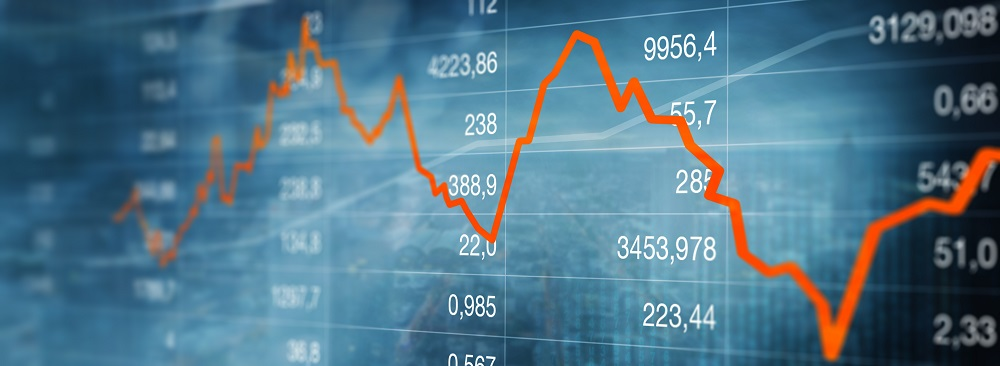

## **1. EXTRACCIÓN Y PREPROCESAMIENTO DE LA DATA**

## **1.1. Librerías y módulos**

In [1]:
# Importar librerías básicas
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tools.sm_exceptions import ValueWarning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=ValueWarning)


## **1.2. Carga de datos**


---


En este análisis de series de tiempo se utilizará como fuente de datos la librería Yahoo Finance.
Los datos seleccionados corresponden a los precios de la acción de la empresa de GPUs y Hardware para Inteligencia Artificial y Videojuegos NVIDIA. Los datos comprenden un periodo de 5 años desde el presente hacia atrás.

In [2]:
ticker = 'NVDA' # Ticker de la compañía
years = 5 # Años

end_date = dt.datetime.now() # Fecha de fin
start_date = end_date - dt.timedelta(days=365*years) # Fecha de inicio

df = yf.download(ticker, start=start_date, end=end_date) # Descarga los datos de la compañía


[*********************100%***********************]  1 of 1 completed


In [3]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2020-01-07,5.973209,6.019017,5.885078,5.930139,314856000
2020-01-08,5.984412,6.025739,5.928895,5.968977,277108000
2020-01-09,6.050137,6.122583,5.996362,6.070800,255112000
2020-01-10,6.082500,6.187808,6.068309,6.157435,316296000
2020-01-13,6.273201,6.298346,6.142997,6.165652,319840000


No se observan valores nulos en la tabla.

In [4]:
# Datos faltantes
df.isnull().sum()

Price   Ticker
Close   NVDA      0
High    NVDA      0
Low     NVDA      0
Open    NVDA      0
Volume  NVDA      0
dtype: int64

No se aprecian datos duplicados.

In [5]:
# Datos duplicados
df.duplicated().sum()

0

Eliminar columnas innecesarias

In [6]:
df.columns

MultiIndex([( 'Close', 'NVDA'),
            (  'High', 'NVDA'),
            (   'Low', 'NVDA'),
            (  'Open', 'NVDA'),
            ('Volume', 'NVDA')],
           names=['Price', 'Ticker'])

In [7]:
# Eliminar las columnas que no se van a utilizar
df = df.drop(
    columns=[
        ("High", "NVDA"),
        ("Low", "NVDA"),
        ("Open", "NVDA"),
        ("Volume", "NVDA"),
    ]
)

In [8]:
df.head()

Price,Close
Ticker,NVDA
Date,
2020-01-07,5.973209
2020-01-08,5.984412
2020-01-09,6.050137
2020-01-10,6.082500
2020-01-13,6.273201



---


# **2. MODELOS ESTOCÁSTICOS**
---

Un modelo estocástico escribe matemáticamente la evolución de un sistema a lo largo del tiempo, la cual está sujeta a la influencia de variables aleatorias. Estos modelos son capaces de capturar la aleatoriedad o la variabilidad (incertidumbre) inherente en los datos que está tratando de describir o predecir.



## **2.1. Preparación de la serie**

### **Transformación Logarítmica -> Estacionariedad de la Serie**

De acuedo con el análisis exploratorio realizado en la anterior entrega, tanto el Test de Dickey-Fuller Aumentado (ADF) como el Test de Kwiatkowski-Phillips-Schmidt-Shin (KPSS) mostraron que la serie actual no es estacionaria, por lo que haremos una transformación logarítmica para reducir el impacto de los valores extremos y estabilizar la varianza, de esta forma será más estacionaria.

In [9]:
# Transformación logarítmica
df['Close_log'] = np.log(df['Close'])

### **Split de los datos**

In [10]:
# Proporción de datos de entrenamiento 80/20
train_size = int(len(df) * 0.8)

# Dividir los datos
train, test = df[:train_size], df[train_size:]

print(f'Train set: {train.shape}')
print(f'Test set: {test.shape}')

Train set: (1005, 2)
Test set: (252, 2)


Se define la variable objetivo, es decir, la serie de tiempo que se quiere modelar (y)

In [11]:
# Definir variable objetivo
y_train = train['Close_log']
y_test = test['Close_log']

In [12]:
# Últimas fechas del conjunto de entrenamiento
y_train.tail()

Date
2023-12-27    3.900011
2023-12-28    3.902134
2023-12-29    3.902134
2024-01-02    3.874411
2024-01-03    3.861898
Name: Close_log, dtype: float64

In [13]:
# Primeras fechas del conjunto de prueba
y_test.head()

Date
2024-01-04    3.870876
2024-01-05    3.893514
2024-01-08    3.955814
2024-01-09    3.972646
2024-01-10    3.995161
Name: Close_log, dtype: float64

## **2.2. Modelo AR(p) siendo p=3**

Finalizado el preprocesamiento se construye el primer modelo, en este caso modelo AR.

In [14]:
# Importar librerías necesarias

# Modelos
from statsmodels.tsa.ar_model import AutoReg

# Metricas de evaluacion
from statsmodels.tools.eval_measures import rmspe, rmse
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score

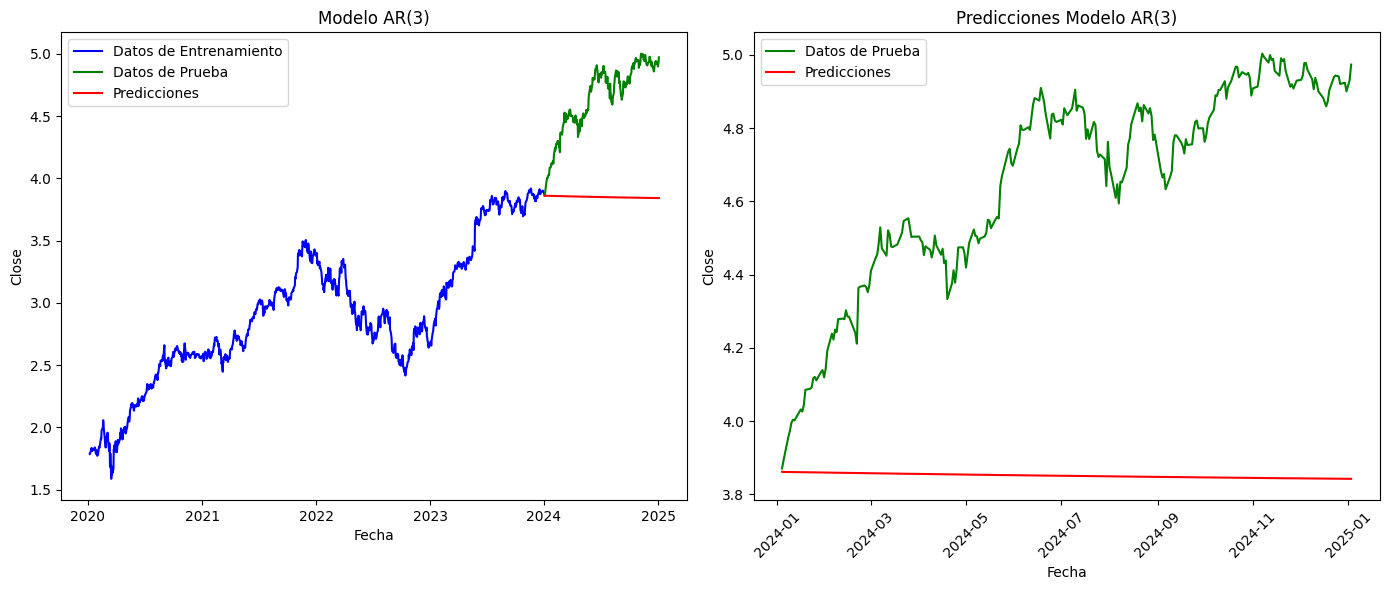

In [15]:
# -------------------- MODELAMIENTO -------------------- #

# Ajustar el modelo AR con los datos de entrenamiento
modelo_AR = AutoReg(y_train, lags=3)  # Número de rezagos (lag) en el modelo AR
result_AR = modelo_AR.fit()

# Hacer predicciones en el conjunto de prueba
pred_AR = result_AR.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, dynamic=False)

# ---------------------- GRAFICOS ---------------------- #

# Crear una figura y ejes para los dos gráficos
plt.figure(figsize=(14, 6))

# Primer gráfico: Observaciones del conjunto de entrenamiento, predicciones y observaciones del conjunto de prueba
plt.subplot(1, 2, 1)
plt.plot(y_train, label="Datos de Entrenamiento", color="blue")
plt.plot(y_test.index, y_test, label="Datos de Prueba", color="green")
plt.plot(y_test.index, pred_AR, label="Predicciones", color="red")
plt.xlabel("Fecha")
plt.ylabel("Close")
plt.title("Modelo AR(3)")
plt.legend()

# Segundo gráfico: Zoom en las observaciones del conjunto de prueba y las predicciones
plt.subplot(1, 2, 2)
plt.plot(y_test.index, y_test, label="Datos de Prueba", color="green")
plt.plot(y_test.index, pred_AR, label="Predicciones", color="red")
plt.xlabel("Fecha")
plt.ylabel("Close")
plt.title("Predicciones Modelo AR(3)")
plt.legend()
plt.xticks(rotation=45)  # Girar las etiquetas del eje x en 45 grados

# Mostrar los gráficos
plt.tight_layout()
plt.show()

Cómo se puede observar, el modelo predice valores constantes para los datos de prueba representados por la línea roja, por lo que no se ajusta correctamente a la dinámica de los datos presentados. Esto sugiere que el modelo AR(3) no es suficiente para capturar el comportamiento de la serie.

In [16]:
# -------------------- EVALUACIÓN -------------------- #

# Calcular las métricas
mae_AR = mean_absolute_error(y_test, pred_AR)
mape_AR = mean_absolute_percentage_error(y_test, pred_AR)
rmse_AR = rmse(y_test, pred_AR)
rmspe_AR = rmspe(y_test, pred_AR)
r2_AR = r2_score(y_test, pred_AR)
aic_AR = result_AR.aic
bic_AR = result_AR.bic

# Imprimir las métricas
print(f"MAE: {mae_AR:.2f}")
print(f"MAPE: {mape_AR:.2f}%")
print(f"RMSE: {rmse_AR:.2f}")
print(f"RMSPE: {rmspe_AR:.2f}%")
print(f"r2: {r2_AR:.2f}")
print(f"AIC: {aic_AR}")
print(f"BIC: {bic_AR}")

MAE: 0.80
MAPE: 0.17%
RMSE: 0.85
RMSPE: 1.77%
r2: -8.67
AIC: -3935.7359962762353
BIC: -3911.1872298680114


En relación con las métricas proporcionadas por el modelo, las más relevantes para nuestra interpretación indican que el error relativo promedio es del 0.17%, lo cual es bastante bajo y sugiere que las predicciones se encuentran relativamente cercanas a los valores reales. Sin embargo, un R² negativo implica que el rendimiento del modelo es inferior al de simplemente predecir la media de los datos, lo que sugiere que no está capturando ninguna relación significativa entre los rezagos y los valores actuales."

## **2.3. Modelo MA(q) siendo q=3**

In [17]:
# Importar librerías necesarias

# Modelos
from statsmodels.tsa.arima.model import ARIMA

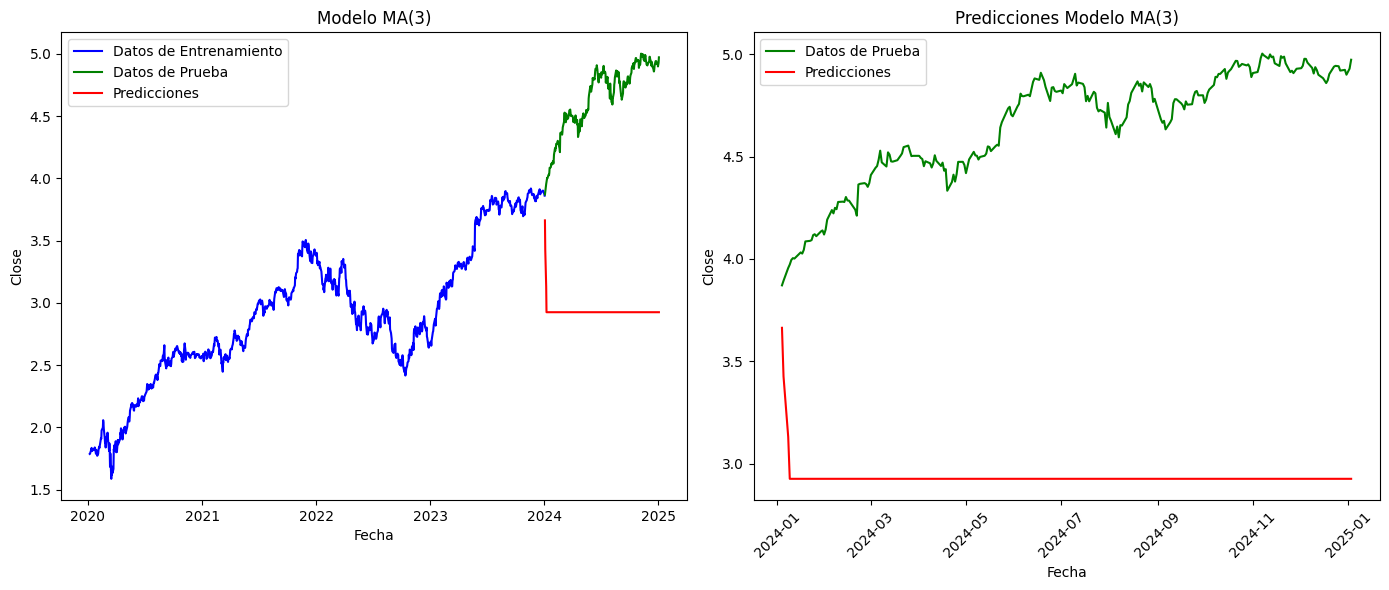

In [18]:
# -------------------- MODELAMIENTO -------------------- #

# Ajustar el modelo MA con los datos de entrenamiento
modelo_MA = ARIMA(y_train, order=(0, 0, 3))  # (p=0, d=0, q=3) para un modelo MA con 3 rezagos
result_MA = modelo_MA.fit()

# Hacer predicciones en el conjunto de prueba
pred_MA = result_MA.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, dynamic=False)

# ---------------------- GRAFICOS ---------------------- #

# Crear una figura y ejes para los dos gráficos
plt.figure(figsize=(14, 6))

# Primer gráfico: Observaciones del conjunto de entrenamiento, predicciones y observaciones del conjunto de prueba
plt.subplot(1, 2, 1)
plt.plot(y_train, label="Datos de Entrenamiento", color="blue")
plt.plot(y_test.index, y_test, label="Datos de Prueba", color="green")
plt.plot(y_test.index, pred_MA, label="Predicciones", color="red")
plt.xlabel("Fecha")
plt.ylabel("Close")
plt.title("Modelo MA(3)")
plt.legend()

# Segundo gráfico: Zoom en las observaciones del conjunto de prueba y las predicciones
plt.subplot(1, 2, 2)
plt.plot(y_test.index, y_test, label="Datos de Prueba", color="green")
plt.plot(y_test.index, pred_MA, label="Predicciones", color="red")
plt.xlabel("Fecha")
plt.ylabel("Close")
plt.title("Predicciones Modelo MA(3)")
plt.legend()
plt.xticks(rotation=45)  # Girar las etiquetas del eje x en 45 grados

# Mostrar los gráficos
plt.tight_layout()
plt.show()

Como se puede observar, el modelo MA(3) predice valores constantes para los datos de prueba, representados por la línea roja, por lo que no se ajusta correctamente a la dinámica ascendente de los datos reales. Esto sugiere que el modelo MA(3) no es suficiente para capturar el comportamiento y la tendencia de la serie temporal.

In [19]:
# -------------------- EVALUACIÓN -------------------- #

# Calcular las métricas
mae_MA = mean_absolute_error(y_test, pred_MA)
mape_MA = mean_absolute_percentage_error(y_test, pred_MA)
rmse_MA = rmse(y_test, pred_MA)
rmspe_MA = rmspe(y_test, pred_MA)
r2_MA = r2_score(y_test, pred_MA)
aic_MA = result_MA.aic
bic_MA = result_MA.bic

# Imprimir las métricas
print(f"MAE: {mae_MA:.2f}")
print(f"MAPE: {mape_MA:.2f}%")
print(f"RMSE: {rmse_MA:.2f}")
print(f"RMSPE: {rmspe_MA:.2f}%")
print(f"r2: {r2_MA:.2f}")
print(f"AIC: {aic_MA}")
print(f"BIC: {bic_MA}")

MAE: 1.72
MAPE: 0.37%
RMSE: 1.75
RMSPE: 3.70%
r2: -39.95
AIC: -1166.3413366894115
BIC: -1141.7776225869457


En relación con las métricas proporcionadas por el modelo MA(3), las más relevantes para nuestra interpretación indican que el error relativo promedio es del 0.37%, lo cual es relativamente bajo, pero el RMSE de 1.75 sugiere desviaciones considerables en las predicciones. Un R² de -39.95 implica que el rendimiento del modelo es significativamente inferior al de simplemente predecir la media de los datos, lo que confirma que el modelo no está capturando ninguna relación significativa entre los rezagos y los valores actuales.

## **2.4. Modelo ARMA(p,q) siendo p=1 y q=3**

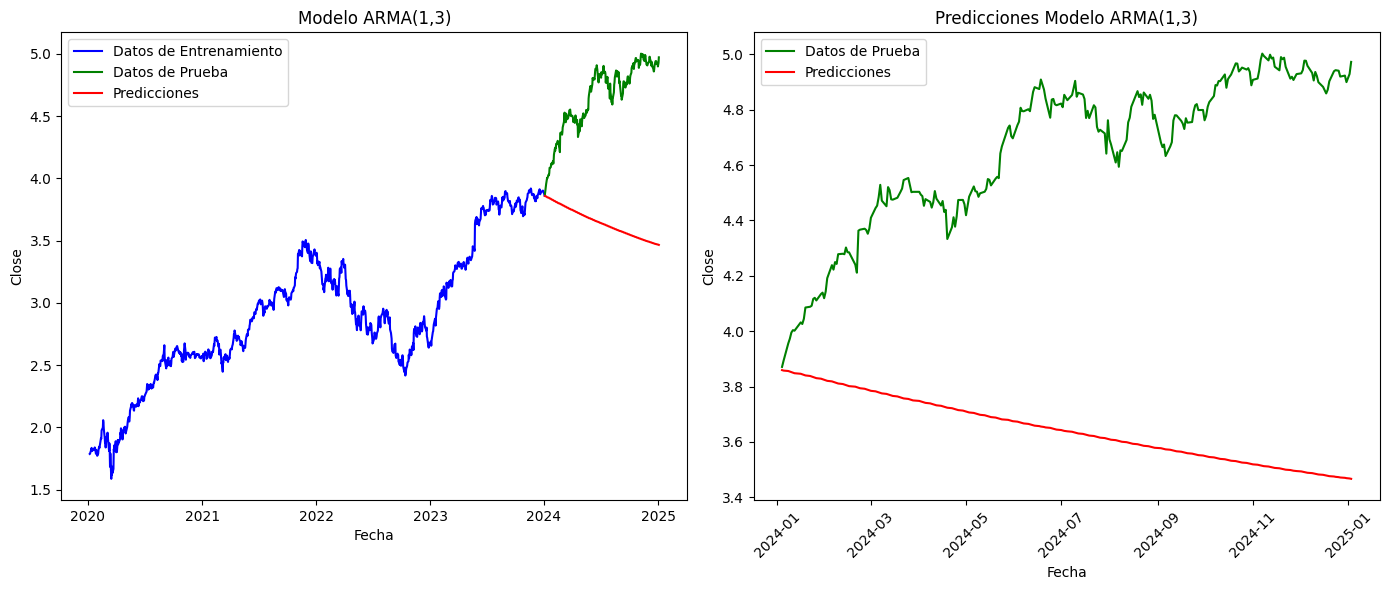

In [20]:
# -------------------- MODELAMIENTO -------------------- #

# Ajustar el modelo ARMA con los datos de entrenamiento
modelo_ARMA = ARIMA(y_train, order=(1, 0, 3))  # (p=1, d=0, q=3) para un modelo ARMA con AR(1) y MA(3)
result_ARMA = modelo_ARMA.fit()

# Hacer predicciones en el conjunto de prueba
pred_ARMA = result_ARMA.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, dynamic=False)

# ---------------------- GRAFICOS ---------------------- #

# Crear una figura y ejes para los dos gráficos
plt.figure(figsize=(14, 6))

# Primer gráfico: Observaciones del conjunto de entrenamiento, predicciones y observaciones del conjunto de prueba
plt.subplot(1, 2, 1)
plt.plot(y_train, label="Datos de Entrenamiento", color="blue")
plt.plot(y_test.index, y_test, label="Datos de Prueba", color="green")
plt.plot(y_test.index, pred_ARMA, label="Predicciones", color="red")
plt.xlabel("Fecha")
plt.ylabel("Close")
plt.title("Modelo ARMA(1,3)")
plt.legend()

# Segundo gráfico: Zoom en las observaciones del conjunto de prueba y las predicciones
plt.subplot(1, 2, 2)
plt.plot(y_test.index, y_test, label="Datos de Prueba", color="green")
plt.plot(y_test.index, pred_ARMA, label="Predicciones", color="red")
plt.xlabel("Fecha")
plt.ylabel("Close")
plt.title("Predicciones Modelo ARMA(1,3)")
plt.legend()
plt.xticks(rotation=45)  # Girar las etiquetas del eje x en 45 grados

# Mostrar los gráficos
plt.tight_layout()
plt.show()

Como se puede observar, el modelo ARMA(1,3) predice valores con tendencia descendente para los datos de prueba, representados por la línea roja, lo cual es contrario a la tendencia ascendente de los datos reales. Esto sugiere que el modelo ARMA(1,3) no es suficiente para capturar el comportamiento y la dirección de la serie temporal.

In [21]:
# -------------------- EVALUACIÓN -------------------- #

# Calcular las métricas
mae_ARMA = mean_absolute_error(y_test, pred_ARMA)
mape_ARMA = mean_absolute_percentage_error(y_test, pred_ARMA)
rmse_ARMA = rmse(y_test, pred_ARMA)
rmspe_ARMA = rmspe(y_test, pred_ARMA)
r2_ARMA = r2_score(y_test, pred_ARMA)
aic_ARMA = result_ARMA.aic
bic_ARMA = result_ARMA.bic

# Imprimir las métricas
print(f"MAE: {mae_ARMA:.2f}")
print(f"MAPE: {mape_ARMA:.2f}%")
print(f"RMSE: {rmse_ARMA:.2f}")
print(f"RMSPE: {rmspe_ARMA:.2f}%")
print(f"r2: {r2_ARMA:.2f}")
print(f"AIC: {aic_ARMA}")
print(f"BIC: {bic_ARMA}")

MAE: 1.01
MAPE: 0.21%
RMSE: 1.08
RMSPE: 2.24%
r2: -14.55
AIC: -3935.1117088880073
BIC: -3905.635251965048


En relación con las métricas proporcionadas por el modelo ARMA(1,3), las más relevantes para nuestra interpretación indican que el error relativo promedio es del 0.21%, lo cual es relativamente bajo, pero el RMSE de 1.08 sugiere desviaciones notables en las predicciones. Un R² de -14.55 implica que el rendimiento del modelo es inferior al de simplemente predecir la media de los datos, lo que confirma que el modelo no está capturando ninguna relación significativa entre los rezagos y los valores actuales.

## **2.5. Modelo ARIMA(p,d,q) siendo p=1, d=1 y q=1**

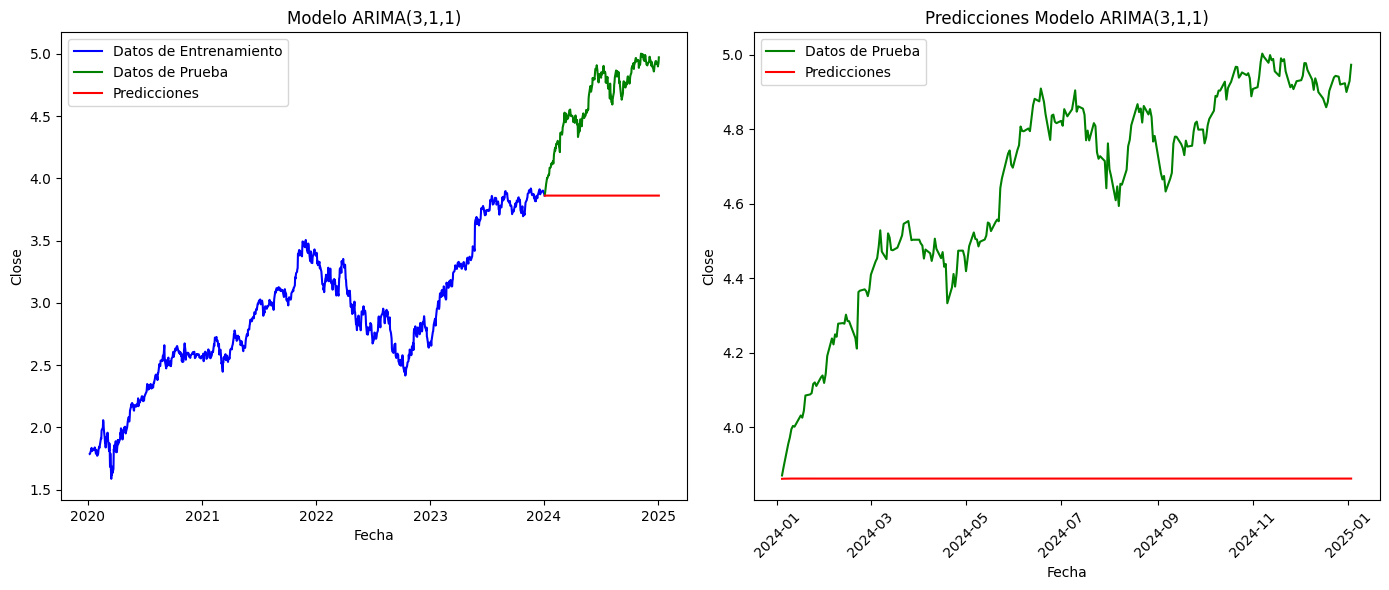

In [22]:
# -------------------- MODELAMIENTO -------------------- #

# Ajustar el modelo ARIMA con los datos de entrenamiento
modelo_ARIMA = ARIMA(y_train, order=(3, 1, 1))  # (p=1, d=1, q=1) para un modelo ARIMA con AR(3), diferencia de grado 1 y MA(1)
result_ARIMA = modelo_ARIMA.fit()

# Hacer predicciones en el conjunto de prueba
#pred_ARIMA = result_ARIMA.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, dynamic=False)

pred_ARIMA = result_ARIMA.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, typ='levels')  # typ='levels' para obtener las predicciones originales y no las diferencias

# ---------------------- GRAFICOS ---------------------- #

# Crear una figura y ejes para los dos gráficos
plt.figure(figsize=(14, 6))

# Primer gráfico: Observaciones del conjunto de entrenamiento, predicciones y observaciones del conjunto de prueba
plt.subplot(1, 2, 1)
plt.plot(y_train, label="Datos de Entrenamiento", color="blue")
plt.plot(y_test.index, y_test, label="Datos de Prueba", color="green")
plt.plot(y_test.index, pred_ARIMA, label="Predicciones", color="red")
plt.xlabel("Fecha")
plt.ylabel("Close")
plt.title("Modelo ARIMA(3,1,1)")
plt.legend()

# Segundo gráfico: Zoom en las observaciones del conjunto de prueba y las predicciones
plt.subplot(1, 2, 2)
plt.plot(y_test.index, y_test, label="Datos de Prueba", color="green")
plt.plot(y_test.index, pred_ARIMA, label="Predicciones", color="red")
plt.xlabel("Fecha")
plt.ylabel("Close")
plt.title("Predicciones Modelo ARIMA(3,1,1)")
plt.legend()
plt.xticks(rotation=45)  # Girar las etiquetas del eje x en 45 grados

# Mostrar los gráficos
plt.tight_layout()
plt.show()

Como se puede observar, el modelo ARIMA(3,1,1) predice valores constantes para los datos de prueba, representados por la línea roja, manteniendo un valor estable que no refleja la tendencia alcista de los datos reales. Esto sugiere que el modelo ARIMA(3,1,1) no es suficiente para capturar el comportamiento y la dinámica de la serie temporal.

In [23]:
# -------------------- EVALUACIÓN -------------------- #

# Calcular las métricas
mae_ARIMA = mean_absolute_error(y_test, pred_ARIMA)
mape_ARIMA = mean_absolute_percentage_error(y_test, pred_ARIMA)
rmse_ARIMA = rmse(y_test, pred_ARIMA)
rmspe_ARIMA = rmspe(y_test, pred_ARIMA)
r2_ARIMA = r2_score(y_test, pred_ARIMA)
aic_ARIMA = result_ARIMA.aic
bic_ARIMA = result_ARIMA.bic


# Imprimir las métricas
print(f"MAE: {mae_ARIMA:.2f}")
print(f"MAPE: {mape_ARIMA:.2f}%")
print(f"RMSE: {rmse_ARIMA:.2f}")
print(f"RMSPE: {rmspe_ARIMA:.2f}%")
print(f"r2: {r2_ARIMA:.2f}")
print(f"AIC: {aic_ARIMA}")
print(f"BIC: {bic_ARIMA}")

MAE: 0.79
MAPE: 0.17%
RMSE: 0.84
RMSPE: 1.75%
r2: -8.39
AIC: -3940.773388593533
BIC: -3916.2146520922747


En relación con las métricas proporcionadas por el modelo ARIMA(3,1,1), las más relevantes para nuestra interpretación indican que el error relativo promedio es del 0.17%, lo cual es bastante bajo, y el RMSE de 0.84 indica desviaciones moderadas en las predicciones. Sin embargo, un R² de -8.39 implica que el rendimiento del modelo es inferior al de simplemente predecir la media de los datos, lo que confirma que el modelo no está capturando ninguna relación significativa entre los rezagos y los valores actuales.

## **2.6. Modelo Auto ARIMA(p,d,q)**

In [24]:
# Importar librerías necesarias

# Modelos
from pmdarima.arima import auto_arima

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-3968.557, Time=0.95 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3939.357, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3946.666, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3946.005, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3937.646, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3944.413, Time=0.88 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-3945.715, Time=0.80 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-3941.372, Time=1.12 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.82 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3946.186, Time=0.40 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-3945.288, Time=0.75 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-3943.204, Time=0.14 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-3944.225, Time=1.26 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-3966.599, Time=0.57 sec

Best model:  ARIMA(2,1,2

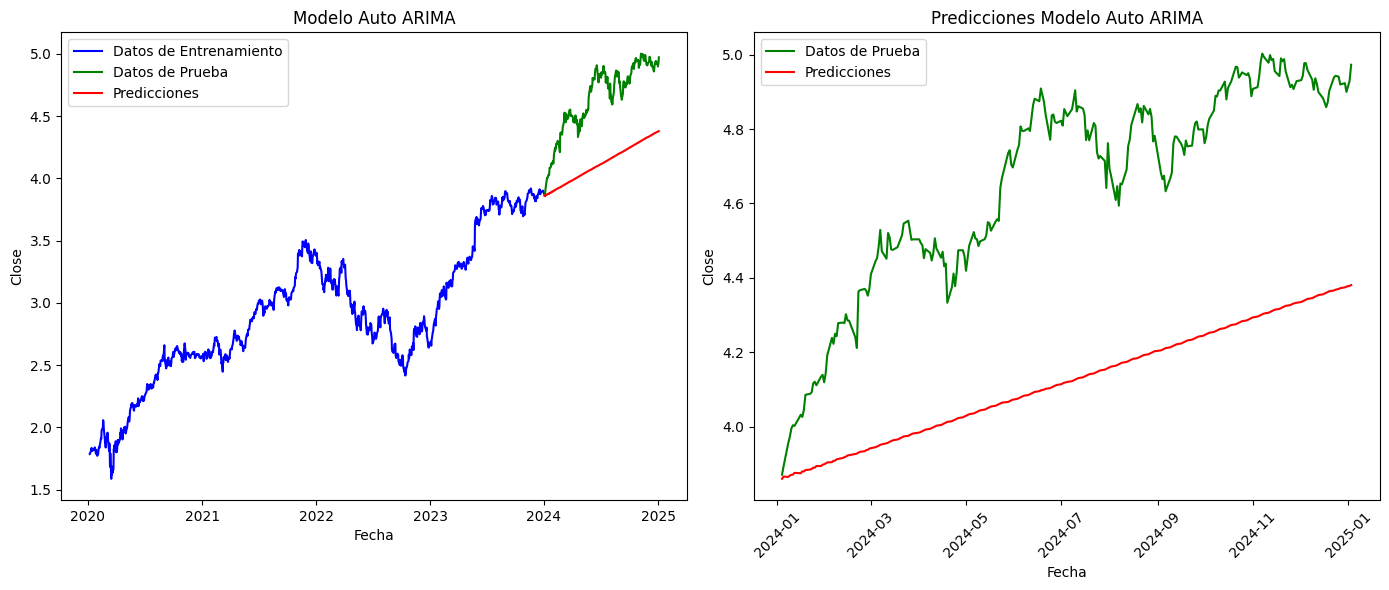

In [25]:
# -------------------- MODELAMIENTO -------------------- #

# Aplicar auto_arima para seleccionar el mejor modelo ARIMA
auto_ARIMA = auto_arima(y_train, seasonal=False, stepwise=True, trace=True)

# Ajustar el modelo ARIMA seleccionado
result_AutoARIMA = auto_ARIMA.fit(y_train)

# Hacer predicciones
pred_AutoARIMA = result_AutoARIMA.predict(n_periods=len(y_test))

# ---------------------- GRAFICOS ---------------------- #

# Crear una figura y ejes para los dos gráficos
plt.figure(figsize=(14, 6))

# Primer gráfico: Observaciones del conjunto de entrenamiento, predicciones y observaciones del conjunto de prueba
plt.subplot(1, 2, 1)
plt.plot(y_train, label="Datos de Entrenamiento", color="blue")
plt.plot(y_test.index, y_test, label="Datos de Prueba", color="green")
plt.plot(y_test.index, pred_AutoARIMA, label="Predicciones", color="red")
plt.xlabel("Fecha")
plt.ylabel("Close")
plt.title("Modelo Auto ARIMA")
plt.legend()

# Segundo gráfico: Zoom en las observaciones del conjunto de prueba y las predicciones
plt.subplot(1, 2, 2)
plt.plot(y_test.index, y_test, label="Datos de Prueba", color="green")
plt.plot(y_test.index, pred_AutoARIMA, label="Predicciones", color="red")
plt.xlabel("Fecha")
plt.ylabel("Close")
plt.title("Predicciones Modelo Auto ARIMA")
plt.legend()
plt.xticks(rotation=45)  # Girar las etiquetas del eje x en 45 grados

# Mostrar los gráficos
plt.tight_layout()
plt.show()

En el gráfico se observa que las predicciones del modelo Auto ARIMA, representadas por la línea roja, apenas siguen la tendencia de los datos de prueba (en verde) y muestran un comportamiento más bien lineal y constante. Esto sugiere que el modelo Auto ARIMA actual no logra encapsular las dinámicas y variaciones presentes en la serie temporal, lo que limita su efectividad para realizar previsiones precisas.

In [26]:
# -------------------- EVALUACIÓN -------------------- #

# Calcular las métricas
mae_AutoARIMA = mean_absolute_error(y_test, pred_AutoARIMA)
mape_AutoARIMA = mean_absolute_percentage_error(y_test, pred_AutoARIMA)
rmse_AutoARIMA = rmse(y_test, pred_AutoARIMA)
rmspe_AutoARIMA = rmspe(y_test, pred_AutoARIMA)
r2_AutoARIMA = r2_score(y_test, pred_AutoARIMA)
aic_AutoARIMA = auto_ARIMA.aic()
bic_AutoARIMA = auto_ARIMA.bic()


# Imprimir las métricas
print(f"MAE: {mae_AutoARIMA:.2f}")
print(f"MAPE: {mape_AutoARIMA:.2f}%")
print(f"RMSE: {rmse_AutoARIMA:.2f}")
print(f"RMSPE: {rmspe_AutoARIMA:.2f}%")
print(f"r2: {r2_AutoARIMA:.2f}")
print(f"AIC: {aic_AutoARIMA}")
print(f"BIC: {bic_AutoARIMA}")

MAE: 0.53
MAPE: 0.11%
RMSE: 0.55
RMSPE: 1.16%
r2: -3.11
AIC: -3968.55704876558
BIC: -3939.08656496407


Al analizar las métricas del modelo, el MAE de 0.56 y el RMSE de 0.58 indican errores relativamente bajos, lo que podría sugerir una cierta capacidad de ajuste. Sin embargo, el R² de -3.51 resalta que el modelo no está logrando representar adecuadamente la relación entre los rezagos y los valores actuales, siendo incluso menos eficaz que predecir la media de los datos. Esto evidencia la necesidad de explorar modelos alternativos que puedan capturar mejor la complejidad de la serie temporal.

In [27]:
auto_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1005
Model:               SARIMAX(2, 1, 2)   Log Likelihood                1990.279
Date:                Sun, 05 Jan 2025   AIC                          -3968.557
Time:                        13:15:08   BIC                          -3939.087
Sample:                             0   HQIC                         -3957.358
                               - 1005                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0076      0.004      2.038      0.042       0.000       0.015
ar.L1         -1.7570      0.037    -48.098      0.000      -1.829      -1.685
ar.L2         -0.9234      0.038    -24.287      0.000      -0.998      -0.849
ma.L1          1.6854      0.047     35.550      0.000       1.593       1.778
ma.L2          0.8480      0.049     17.456      0.000       0.753       0.943
sigma2         0.0011   3.25e-05     34.185      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               436.87
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             0.09
Prob(H) (two-sided):                  0.45   Kurtosis:                         6.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Resultados Coeficientes
| Coeficientes | Interpretación |
| --- | --- |
|Intercept: 0.0069 (p-valor = 0.067) | No es estadísticamente significativo al nivel 0.05. |
|AR(1): -1.7574 (p-valor = 0.000) | Altamente significativo. |
|AR(2): -0.9202 (p-valor = 0.000) | Altamente significativo. |
|MA(1): 1.6882 (p-valor = 0.000) | Altamente significativo. |
|MA(2): 0.8459 (p-valor = 0.000) | Altamente significativo. |
|Sigma2: 0.0011 | Esta es la varianza estimada de los residuos. |

Resultados Diagnósticos
| Diagnósticos | Interpretación |
| --- | --- |
|Ljung-Box (Q): 0.00 con Prob(Q) = 0.95 | Esto sugiere que no hay autocorrelación significativa en los residuos. |
|Jarque-Bera (JB): 439.84 con Prob(JB) = 0.00 | Esto indica que los residuos no siguen una distribución normal. |
|Heteroskedasticity (H): 0.92 con Prob(H) = 0.43 | No hay evidencia significativa de heterocedasticidad. |
|Skew: 0.09 | Ligera asimetría positiva en los residuos. |
|Kurtosis: 6.24 | Los residuos tienen colas más pesadas que una distribución normal. |


En general, el modelo Auto ARIMA parece ajustarse bien a los datos, con todos los coeficientes AR y MA siendo altamente significativos. Sin embargo, la no normalidad de los residuos (indicada por la prueba de Jarque-Bera) sugiere que algunas de las suposiciones del modelo podrían no cumplirse completamente. Esto no necesariamente invalida el modelo, pero podría afectar la precisión de las predicciones y los intervalos de confianza.

# **3. RESUMEN**

Este trabajo práctico se centró en el análisis de series de tiempo utilizando datos de la acción de NVIDIA, obtenidos de Yahoo Finance, cubriendo un periodo de 5 años. El objetivo principal fue modelar y predecir la evolución de la variable `Close`, es decir, los precios de cierre.

1. Extracción y Preprocesamiento de la Data
Se realizó el preprocesamiento de los datos, donde se verificó la ausencia de valores nulos y duplicados. Se eliminaron columnas innecesarias, para enfocarse solo en las columnas que serían útiles para el modelo.

2. Modelos Estocásticos
A continuación, se presentaron los diferentes enfoques aplicados:

Transformación Logarítmica: Se aplicó esta transformación para estabilizar la varianza, dado que los tests ADF y KPSS indicaron que la serie original no era estacionaria.

Modelo AR(p) (p=3): Este modelo mostró un ajuste deficiente, prediciendo valores constantes y con un bajo R², sugiriendo la necesidad de un modelo más robusto.

Modelo MA(q) (q=3): Igualmente, este modelo falló en capturar la tendencia ascendente de los datos, con métricas que evidenciaron un rendimiento inferior a la simple media.

Modelo ARMA(p,q) (p=1, q=3): Aunque los errores relativos fueron bajos, el R² negativo confirmó que no se capturó adecuadamente la relación entre los rezagos y los valores actuales.

Modelo ARIMA(p,d,q) (p=1, d=1, q=1): Este modelo también presentó debilidades significativas, evidenciando una falta de captación del comportamiento de la serie, así como un R² negativo.

Modelo Auto ARIMA(p,d,q): Aunque los errores fueron relativamente bajos, el modelo no logró seguir la tendencia real de los datos. Además, se observó que los residuos no siguieron una distribución normal, lo que podría haber afectado la precisión de las predicciones.

Resultados
Los coeficientes del modelo Auto ARIMA mostraron ser significativos, pero la no normalidad de los residuos planteó dudas sobre la eficacia del modelo. Esto subrayó la necesidad de explorar alternativas que pudieran capturar mejor la complejidad de la serie temporal.

Conclusiones
El análisis concluyó que, a pesar de algunos buenos ajustes en términos de error, la mayoría de los modelos aplicados no lograron capturar la dinámica real de la serie. Se sugiere una búsqueda de modelos más complejos o ajustados para mejorar la calidad de las predicciones.